In [1]:
import bioframe as bf
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mp
from pybedtools import BedTool
import HMMC
import numpy as np
import os


mp.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure2S/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    mp.rcParams.update(new_rc_params)

In [2]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep = '\t')

In [3]:
chrom_hmm_dir = '/pollard/data/wynton/consortia/roadmap/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final'
gm_chrom =  chrom_hmm_dir+'/E116_15_coreMarks_hg38lift_mnemonics.bed.gz'
gm_chrom_df = BedTool(gm_chrom).to_dataframe(skiprows=1)

In [4]:
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
resolution = 25000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

In [5]:
region = 'chr9:85,731,459-93,165,754'
# region = 'chr1:13,958,846-41,444,480'
annotation_type = 'HMM3P'
chrom_state = '14_ReprPCWk'

In [6]:
chromhmm_region = bf.select(gm_chrom_df, region).copy()
genome_region = bf.select(hmm_track, region).copy()
genome_region.drop(columns=hmm_track.columns[3:], inplace=True)

chromhmm_region['signal']=0
chromhmm_region.loc[chromhmm_region.name==chrom_state, 'signal']=1

In [7]:
from bioframe.util import bedtools
def bedtools_intersect_basePairs(left, right, rsuffix='_', **kwargs):
    """
    >>> ixn = bedtools_intersect(bed1, bed2, wao=True), needed to delete other keys b/c they clashed
   """
    
    out = bedtools.intersect(a=left, b=right,wao=True)
    out.columns = list(left.columns) + [c+rsuffix if c in left.columns else c for c in right.columns] + ['bpOverlap']
    return out

In [8]:
inter = bedtools_intersect_basePairs(genome_region, chromhmm_region[chromhmm_region.signal==1])

In [9]:
genome_region['overlap'] = inter.groupby(by=['chrom','start']).sum().bpOverlap.values

In [10]:
height, width = 9, 7

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


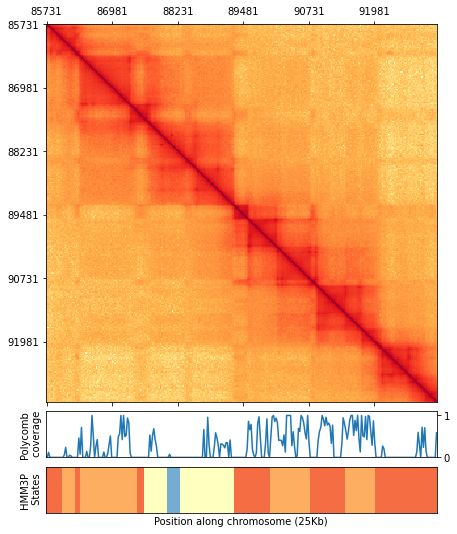

In [11]:
fig= plt.figure(1, figsize = (width, height))
gs = gridspec.GridSpec(height, width, figure=fig, wspace=2, hspace=0.2)

ax0= plt.subplot(gs[:7, :])
mat = hic_cooler.matrix(balance=True).fetch(region, region)
res = hic_cooler.binsize
im = ax0.matshow(np.log10(mat + 5e-6),cmap = 'YlOrRd', aspect='auto', interpolation ='none')

chrm, start, end = bf.parse_region(region)

ax0.yaxis.set_ticks_position('left')
ticklabels = ((ax0.yaxis.get_ticklocs()*res/1e3)+(start)/1e3).astype(int)
ax0.yaxis.set_ticklabels(ticklabels)
ax0.xaxis.set_ticklabels(ticklabels)





ax1= plt.subplot(gs[7:8, :])
ax1.plot(genome_region.start, genome_region.overlap/res)
ax1.margins(0)

ax1.set_ylabel('Polycomb\n coverage',rotation=90)
ax1.get_xaxis().set_visible(False)
ax1.yaxis.tick_right()
ax1.set_ylim([0, 1.1])





ax2= plt.subplot(gs[8:9, :])
mat_c = HMMC.track_to_mat(hmm_track, region, annotation_type, HMMC.pallete, horizontal=True)
ax2.matshow(mat_c,cmap=mp.colors.ListedColormap(HMMC.cmap), vmin=0, vmax=5, aspect='auto')

ax2.set_ylabel('HMM3P\n States',rotation=90)
ax2.yaxis.tick_right()
ax2.get_yaxis().set_ticks([])


ax2.set_xlabel('Position along chromosome (25Kb)')
ax2.get_xaxis().set_ticks([]);

# if saveFigs:
#     plt.savefig(figure_path+'hicseg_'+region.replace(',','')+'_'
#                 +annotation_type+'.svg',
#                 bbox_inches="tight")